## 0. Introduction

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via custom datasets.

### Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

In [62]:
import torch
from torch import nn

In [63]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Get Data

Our dataset is a subset of the Food101 dataset.

Food101 starts with 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, ~25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [64]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data")
image_path = data_path / "food-vision"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping directory creation")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

data/food-vision directory already exists... skipping directory creation


In [65]:
zipfile_path = data_path / "pizza_steak_sushi.zip"

if not zipfile_path.exists():
    # Download pizza, steak and sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

In [66]:
# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, and sushi data...")
    zip_ref.extractall(image_path)

Unzipping pizza, steak, and sushi data...


## 2. Becoming one with the data (data preperation and explorative data analysis)

In [67]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path, returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [68]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/food-vision'.
There are 3 directories and 0 images in 'data/food-vision/train'.
There are 0 directories and 78 images in 'data/food-vision/train/pizza'.
There are 0 directories and 75 images in 'data/food-vision/train/steak'.
There are 0 directories and 72 images in 'data/food-vision/train/sushi'.
There are 3 directories and 0 images in 'data/food-vision/test'.
There are 0 directories and 25 images in 'data/food-vision/test/pizza'.
There are 0 directories and 19 images in 'data/food-vision/test/steak'.
There are 0 directories and 31 images in 'data/food-vision/test/sushi'.


In [69]:
# Setup training and testing path
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths.
2. Pick a random image using Python's random.choice().
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL.
5. We'll then show the image and print metadata.

Random image path: data/food-vision/train/pizza/2885796.jpg
Image class: pizza
Image height: 512
Image width: 512


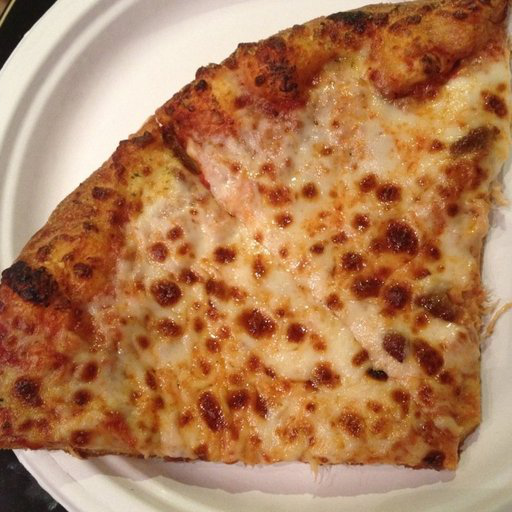

In [70]:
import random
from PIL import Image

# 1. Get all of the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image using Python's random.choice()
random_image_path = random.choice(image_path_list)

# 3. Get the image class name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

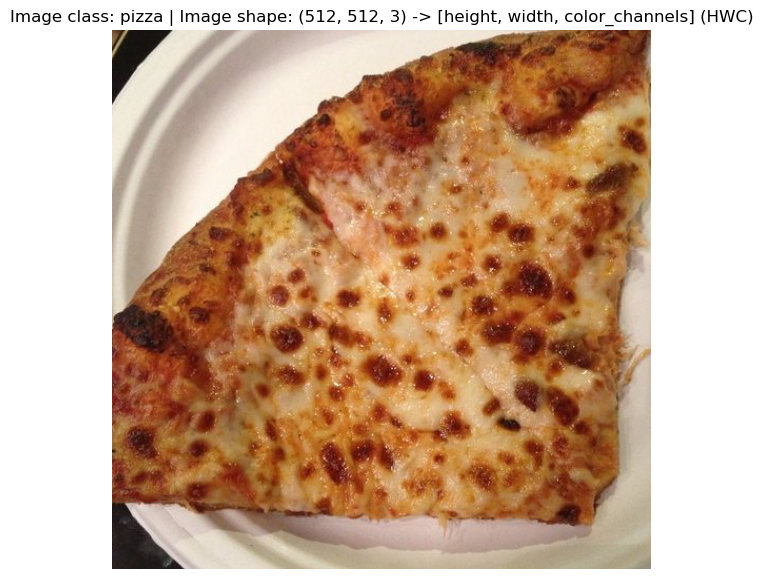

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [72]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/main/transforms.html

In [73]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [74]:
data_transform(img).shape

torch.Size([3, 64, 64])

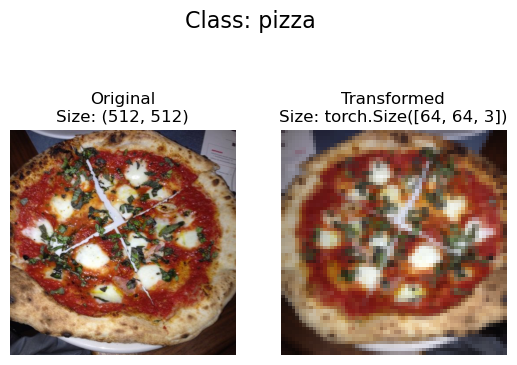

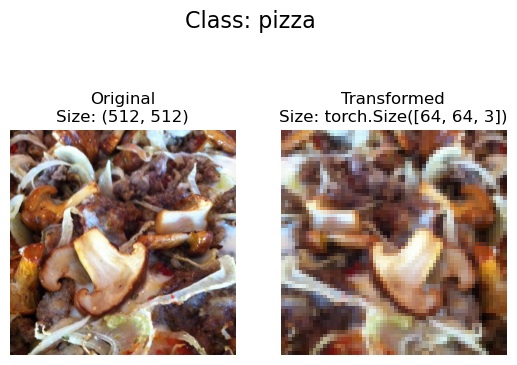

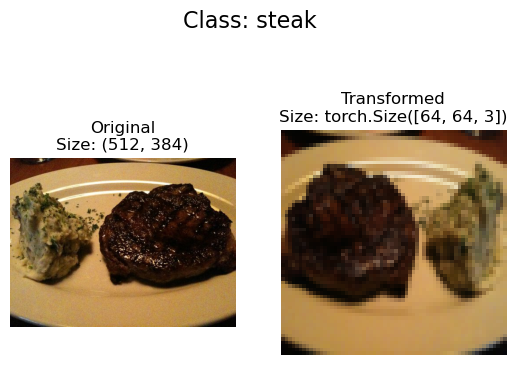

In [75]:
def plot_transformed_images(image_paths: list, transform, n=3):
    """
    Selects random images from a path of images and loads/transforms them, then plots the 
    original vs the transformed version.
    """
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list, transform=data_transform)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [76]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for the data
                                  target_transform=None)    # transform for the target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/food-vision/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/food-vision/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [77]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [78]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [79]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [80]:
# Print labels of first three and sample of first image
train_data.targets[:3], train_data.samples[0]

([0, 0, 0], ('data/food-vision/train/pizza/1008844.jpg', 0))

In [81]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Pytorch: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Matplotlib: torch.Size([64, 64, 3]) -> [height, width, color_channels]


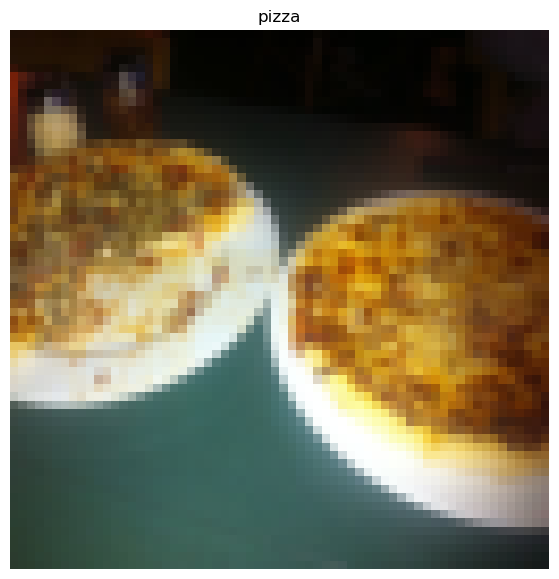

In [82]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Pytorch: {img.shape} -> [color_channels, height, width]")
print(f"Matplotlib: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label]);

## 4.1 Turn loaded images into `DataLoader`

A `DataLoader` is going to help us turn our `Dataset` into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [83]:
# Turn train and test datasets into DataLoader'set
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count())

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x707449e67320>,
 <torch.utils.data.dataloader.DataLoader at 0x707449c38980>)

In [84]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [85]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file.
2. Want to be able to get class names from the Dataset.
3. Want to be able to get classes as classes as dictionary from the Dataset.

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions.

Cons:
* Even though you could create a `Dataset` out of almost anythinig, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues.

In [86]:
import pathlib
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the direcotry structure).
3. Turn the class names into a dict and a list and return them.

In [87]:
# Setup the path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/food-vision/train


['pizza', 'steak', 'sushi']

In [88]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Find the class folder names in a target directory."""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")
    
    # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

In [89]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image.
5. Override the `__len()__` method to return the length of our dataset.
6. Override the `__getitem()__` method to return a given sample when passed an index

In [90]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, targ_dir: str, transform=None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """Opens an image via a path and returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__()
    def __len__(self) -> int:
        """Returns the total number of sampels"""
        return len(self.paths)
    
    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, data and label (X, y)"""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name  # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx   # return data, label (X, y)
        else:
            return img, class_idx                   # return untransformed image and label

In [91]:
img, label = train_data[0]
img, label

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [92]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

In [93]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [94]:
len(train_data), len(train_data_custom), len(test_data), len(test_data_custom), (train_data_custom.classes == train_data.classes)

(225, 225, 75, 75, True)

### 5.3 Create a function to display random images

1. Take a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC).
8. Plot adjusted samples.

In [95]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # 8. Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title += f"\nShape: {targ_image_adjust.shape}" 
        plt.title(title)

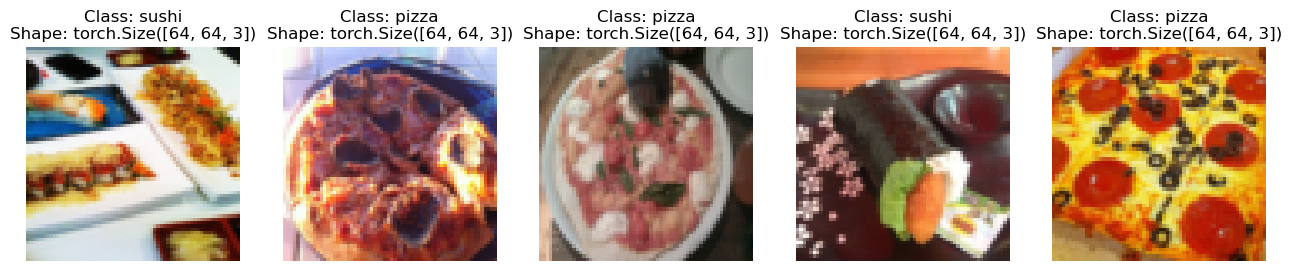

In [96]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


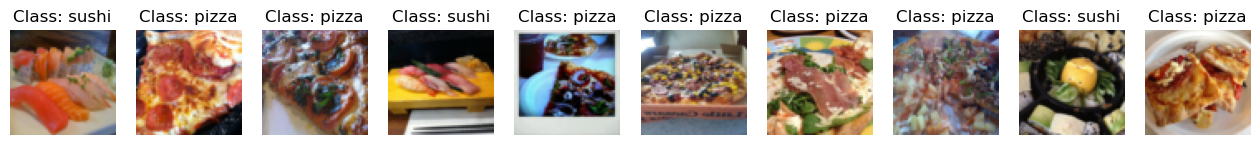

In [97]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [98]:
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x70743b1d5f10>,
 <torch.utils.data.dataloader.DataLoader at 0x70743b1d4cb0>)

In [99]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels... - https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [100]:
# Let's look at trivial augment
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [101]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:4]

[PosixPath('data/food-vision/train/pizza/1899785.jpg'),
 PosixPath('data/food-vision/train/pizza/928670.jpg'),
 PosixPath('data/food-vision/train/pizza/2760984.jpg'),
 PosixPath('data/food-vision/train/pizza/3821701.jpg')]

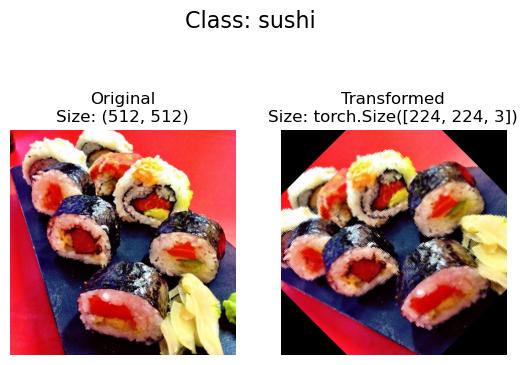

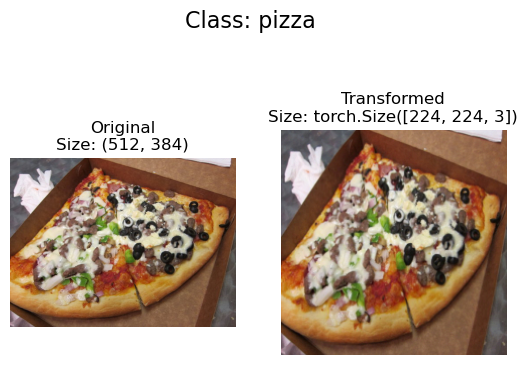

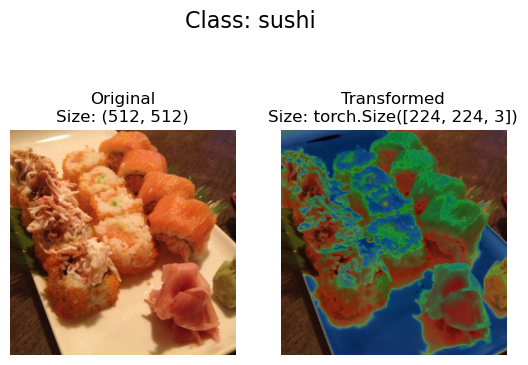

In [102]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture form the CNN Explainer website.

### 7.1 Creating transforms and loading data for Model 0

In [103]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [104]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

In [105]:
# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [106]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from CNN Explainer
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16 * 16,
                        out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        return x

In [107]:
model_0 = TinyVGG(input_shape=3,    # number of color channels in our image
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [108]:
img, label = next(iter(train_dataloader))
model_0(img)

tensor([[0.0528, 0.0010, 0.0151]], grad_fn=<AddmmBackward0>)

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [109]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and datalaoder and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [110]:
# Create train_step()
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metrics to get the average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [111]:
# Create a test step
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [112]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss_fn
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module,
          epochs: int = 5):
    """Initiate the training of a model"""
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)

        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.3f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.3f}")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and evaluate model 0

In [113]:
# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_custom,
                        test_dataloader=test_dataloader_custom,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.102 | Train acc: 0.305 | Test loss: 1.106 | Test acc: 0.260
Epoch: 1 | Train loss: 1.098 | Train acc: 0.305 | Test loss: 1.108 | Test acc: 0.260
Epoch: 2 | Train loss: 1.096 | Train acc: 0.430 | Test loss: 1.108 | Test acc: 0.260
Epoch: 3 | Train loss: 1.097 | Train acc: 0.305 | Test loss: 1.110 | Test acc: 0.260
Epoch: 4 | Train loss: 1.095 | Train acc: 0.426 | Test loss: 1.111 | Test acc: 0.260
Epoch: 5 | Train loss: 1.097 | Train acc: 0.305 | Test loss: 1.112 | Test acc: 0.260
Epoch: 6 | Train loss: 1.103 | Train acc: 0.305 | Test loss: 1.110 | Test acc: 0.260
Epoch: 7 | Train loss: 1.095 | Train acc: 0.426 | Test loss: 1.111 | Test acc: 0.260
Epoch: 8 | Train loss: 1.097 | Train acc: 0.305 | Test loss: 1.112 | Test acc: 0.260
Epoch: 9 | Train loss: 1.103 | Train acc: 0.305 | Test loss: 1.110 | Test acc: 0.260
Total training time: 12.831 seconds


### 7.8 Plot the loss curve of Model 0

A **loss_curve** is a way of tracking our model's progess over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

In [114]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [115]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary"""
    # Get the loss values of the results dictionary (training and test)
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Same for accuracy
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

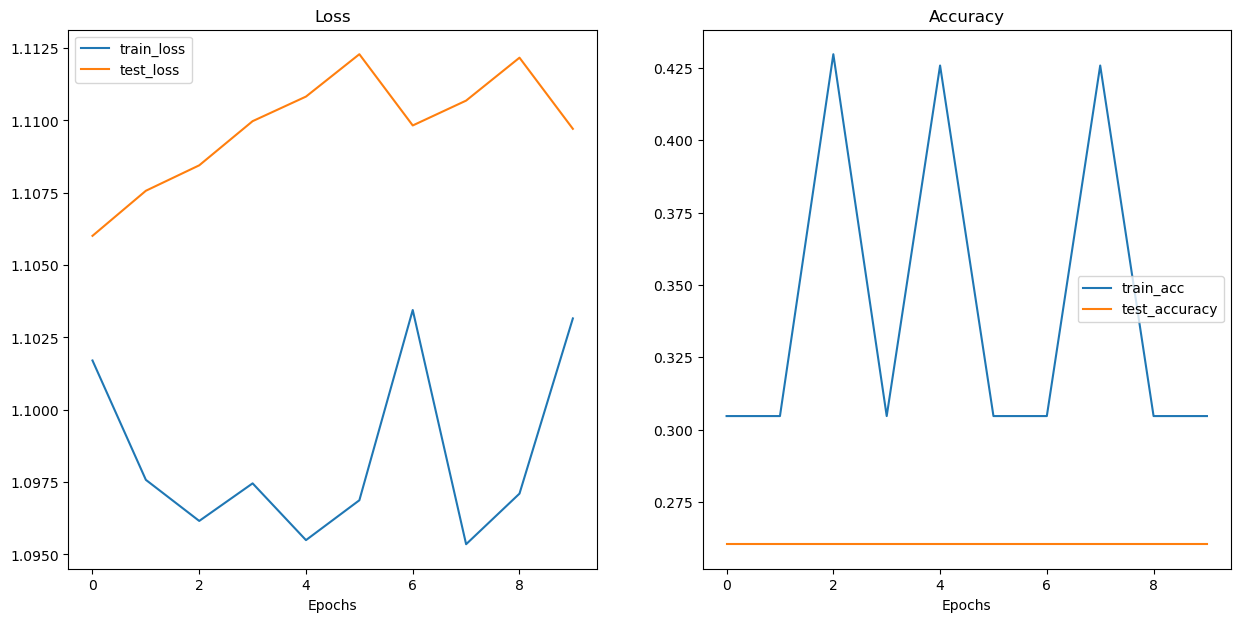

In [116]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

A loss curve is one of the most helpful ways to troubleshoot a model. https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

## 9. Model 1: TinyVGG with Data Augmentation

Now let's try another modelling experiment, this time using the same model as before but with some data augmentation.

### 9.1 Create transform with data augmentation

In [117]:
# Create training transform with TrivialAugment
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [118]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=test_transform_simple)

In [119]:
# Turn our Datasets into DataLoaders
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1

This time we'll be using the same model architecture except this time we've augmented the training data.

In [120]:
# Create model_1 and send it to the target device
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

Wonderful! Now we have a model and dataloaders, let's create a loss function and call upon our `train()` function to train and evaluate our model.

In [121]:
NUM_EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.116 | Train acc: 0.250 | Test loss: 1.117 | Test acc: 0.198
Epoch: 1 | Train loss: 1.113 | Train acc: 0.270 | Test loss: 1.128 | Test acc: 0.260
Epoch: 2 | Train loss: 1.093 | Train acc: 0.305 | Test loss: 1.115 | Test acc: 0.323
Epoch: 3 | Train loss: 1.062 | Train acc: 0.461 | Test loss: 1.102 | Test acc: 0.292
Epoch: 4 | Train loss: 1.084 | Train acc: 0.324 | Test loss: 1.073 | Test acc: 0.302
Epoch: 5 | Train loss: 1.126 | Train acc: 0.395 | Test loss: 1.114 | Test acc: 0.302
Epoch: 6 | Train loss: 1.037 | Train acc: 0.523 | Test loss: 1.121 | Test acc: 0.281
Epoch: 7 | Train loss: 1.083 | Train acc: 0.395 | Test loss: 1.084 | Test acc: 0.333
Epoch: 8 | Train loss: 0.984 | Train acc: 0.520 | Test loss: 0.954 | Test acc: 0.594
Epoch: 9 | Train loss: 1.043 | Train acc: 0.383 | Test loss: 1.051 | Test acc: 0.384
Total training time for model_1: 11.111


### 9.4 Plot the loss curves of model 1

A loss curve helps you evaluate your models performance over time.

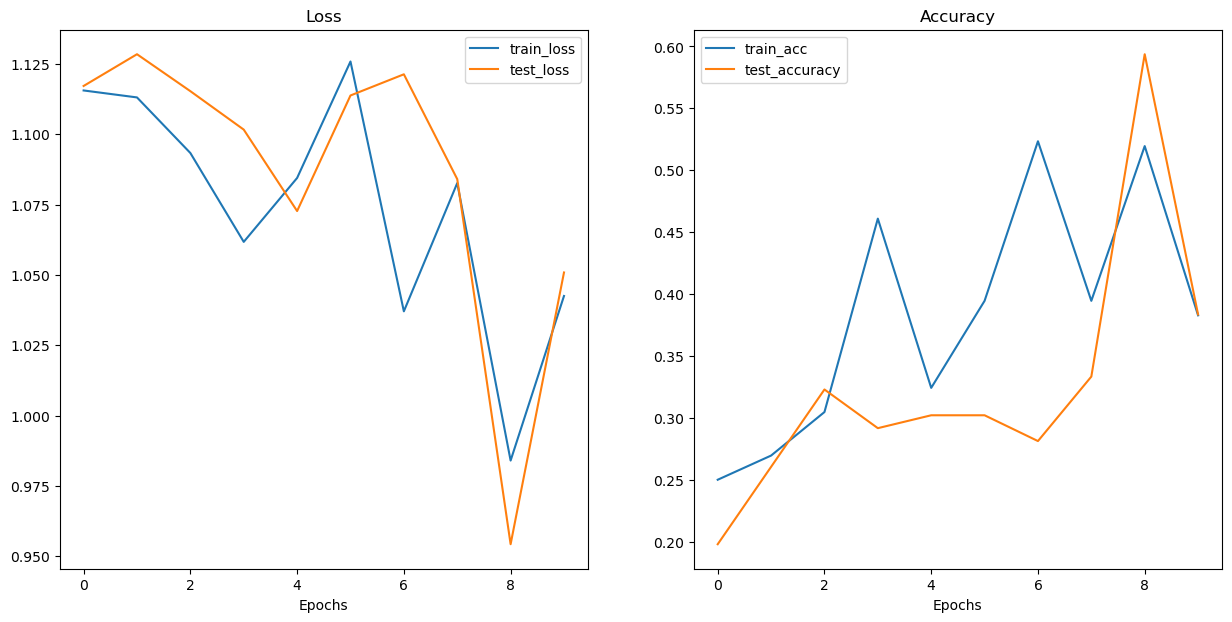

In [122]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (what we are doing)
2. PyTorch + Tensorboard - https://docs.pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site
4. MLFlow - https://mlflow.org/

In [123]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.101704,0.304688,1.106012,0.260417
1,1.097579,0.304688,1.107570,0.260417
2,1.096159,0.429688,1.108449,0.260417
3,1.097458,0.304688,1.109976,0.260417
4,1.095496,0.425781,1.110825,0.260417
5,1.096874,0.304688,1.112289,0.260417
6,1.103449,0.304688,1.109827,0.260417
7,1.095355,0.425781,1.110686,0.260417
8,1.097103,0.304688,1.112169,0.260417
9,1.103158,0.304688,1.109711,0.260417


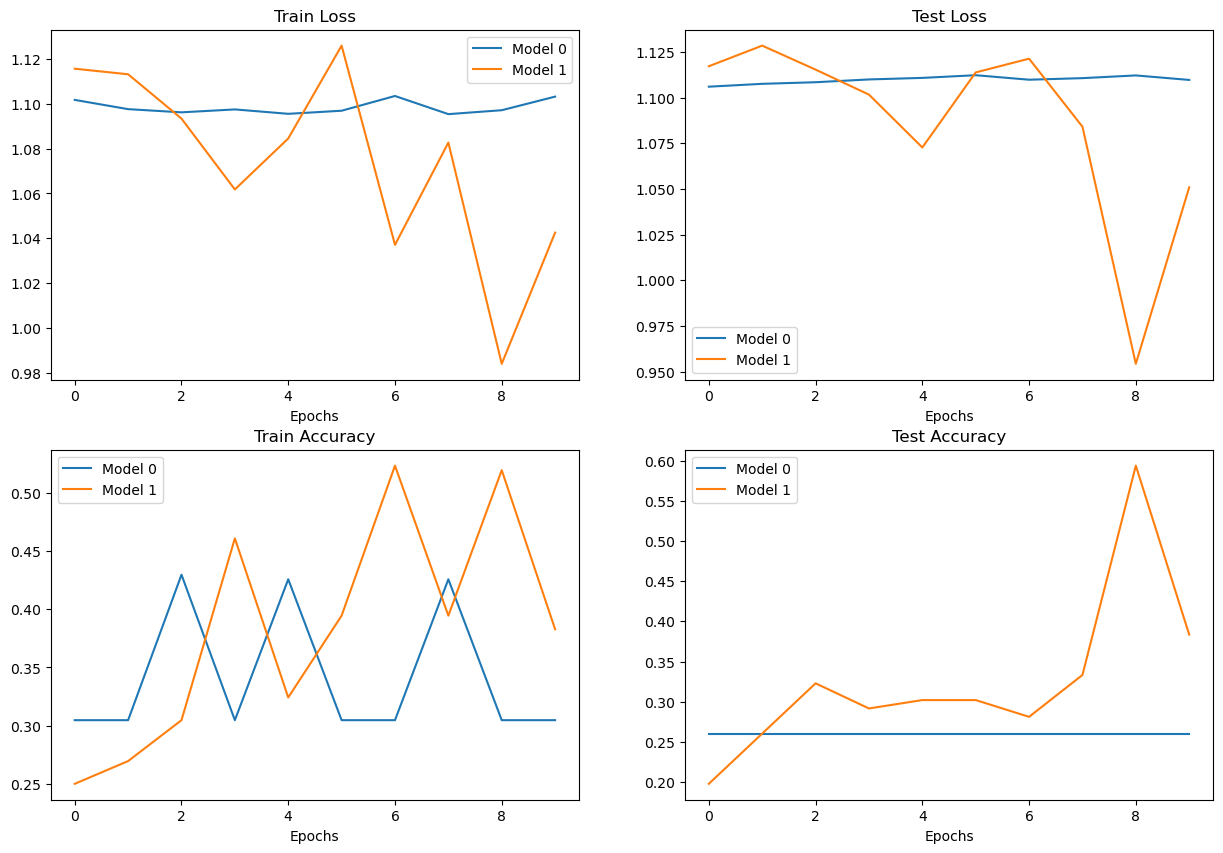

In [124]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend();

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend();

# Plot test loss
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend();

# Plot test loss
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image

Although we have trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset.

In [125]:
# Download custom image
import requests

# Setup custom image path
data_path = Path("data")
custom_image_path = data_path / "05-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/data/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download...")

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

We can read an image into PyTorch using -
https://docs.pytorch.org/vision/0.19/generated/torchvision.io.read_image.html

In [130]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(custom_image_path)
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

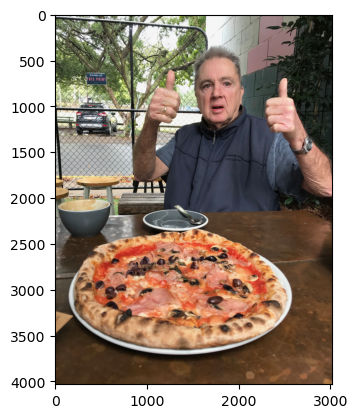

In [129]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [147]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255

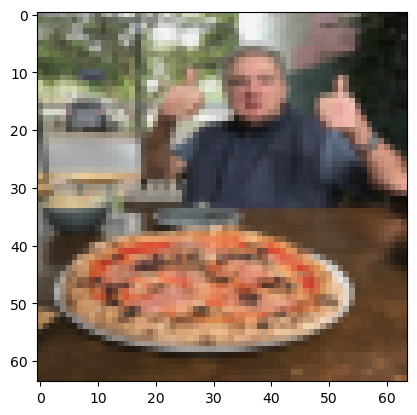

In [153]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

custom_image_transformed = custom_image_transform(custom_image)
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [155]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[-0.2716, -0.0870, -0.3893]])

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the iamge was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* Make sure the image was on the same device as our model

In [ ]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)

In [159]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs)
custom_image_pred_labels

tensor(1)

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [177]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
    """Makes a prediction on a target image with a trained model and plots the image and prediction."""
    # Load in the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Make sure the model is on the target device
    model.to(device)

    # Turn on eval/inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches on 1x image)
        target_image = target_image.unsqueeze(0)

        # Make a prediciton on the image with an extra dimension
        target_image_pred = model(target_image.to(device))  # make sure target_image is on device

    # Convert the logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

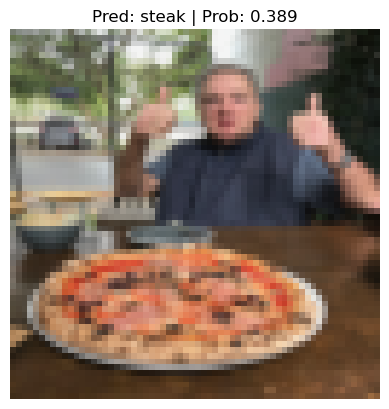

In [178]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)